In [1]:
import torch
import numpy as np
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from datasets import Dataset
import evaluate
from Bio import motifs
from Bio.Seq import Seq
import random
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
import pandas as pd
import os
import pickle
import requests
import ast

src_path = Path("../src")
sys.path.append(str(src_path))

from ts_tf.motifs import fetch_all_motifs, save_to_csv, fetch_all_motif_metadata, save_metadata_to_csv
import ts_tf.protein as prot
import ts_tf.custom_esm as cesm

## RETRIEVE DNA MOTIFS

In [2]:
# Retrieve all high-quality motifs for vertebrates
tax_group = "vertebrates"

try:
    print(f"Fetching high-quality motifs for {tax_group}...")
    all_motifs = fetch_all_motifs(tax_group=tax_group)
    print(f"Retrieved {len(all_motifs)} motifs.")

    # Save motifs to a CSV file
    output_file = "../results/high_quality_motifs_with_pfm_pwm.csv"
    save_to_csv(all_motifs, output_file)
    print(f"Saved motifs to {output_file}")
except ValueError as e:
    print(e)

Fetching high-quality motifs for vertebrates...
Fetching motifs from: http://jaspar.genereg.net/api/v1/matrix/
Fetching motifs from: https://jaspar.elixir.no/api/v1/matrix/?collection=CORE&page=2&quality=high&tax_group=vertebrates
Fetching motifs from: https://jaspar.elixir.no/api/v1/matrix/?collection=CORE&page=3&quality=high&tax_group=vertebrates
Fetching motifs from: https://jaspar.elixir.no/api/v1/matrix/?collection=CORE&page=4&quality=high&tax_group=vertebrates
Fetching motifs from: https://jaspar.elixir.no/api/v1/matrix/?collection=CORE&page=5&quality=high&tax_group=vertebrates
Fetching motifs from: https://jaspar.elixir.no/api/v1/matrix/?collection=CORE&page=6&quality=high&tax_group=vertebrates
Fetching motifs from: https://jaspar.elixir.no/api/v1/matrix/?collection=CORE&page=7&quality=high&tax_group=vertebrates
Fetching motifs from: https://jaspar.elixir.no/api/v1/matrix/?collection=CORE&page=8&quality=high&tax_group=vertebrates
Fetching motifs from: https://jaspar.elixir.no/ap

/hpc/mydata/anton.thieme/projects/TabulaSapiens/notebooks/../src/ts_tf/motifs.py:81: RuntimeWarning: invalid value encountered in divide
  ppm.append(pfm[:][i] / np.sum(pfm[:][i], axis=0)) # Compute PPM for each position


Retrieved PFM for https://jaspar.elixir.no/api/v1/matrix/MA0854.1/: [[19.0, 7.0, 38.0, 43.0, 5.0, 1.0, 98.0, 98.0, 1.0, 0.0, 92.0, 53.0, 15.0, 23.0, 39.0, 24.0, 15.0], [44.0, 21.0, 33.0, 9.0, 40.0, 7.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0, 21.0, 32.0, 31.0, 29.0, 40.0], [17.0, 65.0, 14.0, 31.0, 2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 7.0, 40.0, 11.0, 16.0, 12.0, 23.0, 14.0], [20.0, 7.0, 15.0, 17.0, 53.0, 92.0, 0.0, 1.0, 98.0, 98.0, 1.0, 5.0, 53.0, 29.0, 17.0, 24.0, 31.0]]
Retrieved PFM for https://jaspar.elixir.no/api/v1/matrix/MA0854.2/: [[5.0, 1.0, 98.0, 98.0, 1.0, 0.0, 92.0, 53.0], [40.0, 7.0, 0.0, 0.0, 1.0, 1.0, 0.0, 2.0], [2.0, 0.0, 1.0, 1.0, 0.0, 0.0, 7.0, 40.0], [53.0, 92.0, 0.0, 1.0, 98.0, 98.0, 1.0, 5.0]]
Retrieved PFM for https://jaspar.elixir.no/api/v1/matrix/MA0853.1/: [[16.0, 10.0, 19.0, 40.0, 2.0, 1.0, 99.0, 98.0, 1.0, 0.0, 92.0, 62.0, 17.0, 29.0, 36.0, 23.0, 12.0], [59.0, 24.0, 44.0, 15.0, 34.0, 8.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 23.0, 28.0, 23.0, 29.0, 43.0], [15.0, 56.0, 16.0, 29.0, 1.

### alternative: retrieve cached

In [3]:
output_file = "../results/motif/high_quality_motifs_with_pfm_pwm.csv"
motif_df = pd.read_csv(output_file)
motif_ids = list(motif_df["Motif ID"].unique())
print(f'motif_ids retrieved: {len(motif_ids)}')

motif_ids retrieved: 1912


## RETRIEVE UNIPROT ID

In [ ]:
# Fetch metadata for all motifs
metadata_list = fetch_all_motif_metadata(motif_ids)

# Save metadata to CSV
save_metadata_to_csv(metadata_list, "../results/motif_metadata_2.csv")

In [13]:
import pickle

with open('outfile', 'wb') as fp:
    pickle.dump(metadata_list, fp)

In [4]:
with open ('outfile', 'rb') as fp:
    metadata_list = pickle.load(fp)

In [ ]:
save_metadata_to_csv(metadata_list, "../results/motif/motif_metadata_2.csv")

In [ ]:
metadata_list[634]

### alternative: retrieve cached

In [4]:
metadata_df = pd.read_csv("../results/motif/motif_metadata.csv")
metadata_df

,Matrix ID,Gene Name,UniProt ID,Species,Taxonomy ID
0,MA0634.1,ALX3,O95076,Homo sapiens,9606
1,MA0634.2,ALX3,O95076,Homo sapiens,9606
2,MA0007.2,AR,P10275,Homo sapiens,9606
3,MA1463.1,ARGFX,A6NJG6,Homo sapiens,9606
4,MA1463.2,ARGFX,A6NJG6,Homo sapiens,9606
...,...,...,...,...,...
1907,MA1630.1,Znf281,Q99LI5,Mus musculus,10090
1908,MA0116.1,Znf423,O08961,Rattus norvegicus,10116
1909,MA0621.1,mix-a,P21711,Xenopus laevis,8355
1910,MA0621.2,mix-a,P21711,Xenopus laevis,8355


## RETRIEVE AA SEQUENCE

In [8]:
metadata_df["AA Sequence"] = None

for i, row in metadata_df.iterrows():

    uniprot_id = row["UniProt ID"]
    aa_seq = prot.fetch_uniprot_sequence(uniprot_id)
    metadata_df.loc[i, "AA Sequence"] = aa_seq

print(f"N retrieved successfully: {len(metadata_df[~metadata_df["AA Sequence"].isnull()])}")
metadata_df.to_csv("../results/motif/motif_metadata_with_uniprot.csv", index=False)

Error fetching sequence for UniProt ID nan: 400
Error fetching sequence for UniProt ID nan: 400
Error fetching sequence for UniProt ID nan: 400
N retrieved successfully: 1909


### alternative: retrieve cached

In [5]:
metadata_df = pd.read_csv("../results/motif/motif_metadata_with_uniprot.csv")
metadata_df

,Matrix ID,Gene Name,UniProt ID,Species,Taxonomy ID,AA Sequence
0,MA0634.1,ALX3,O95076,Homo sapiens,9606,MDPEHCAPFRVGPAPGPYVASGDEPPGPQGTPAAAPHLHPAPPRGP...
1,MA0634.2,ALX3,O95076,Homo sapiens,9606,MDPEHCAPFRVGPAPGPYVASGDEPPGPQGTPAAAPHLHPAPPRGP...
2,MA0007.2,AR,P10275,Homo sapiens,9606,MEVQLGLGRVYPRPPSKTYRGAFQNLFQSVREVIQNPGPRHPEAAS...
3,MA1463.1,ARGFX,A6NJG6,Homo sapiens,9606,MRNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKLECSG...
4,MA1463.2,ARGFX,A6NJG6,Homo sapiens,9606,MRNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKLECSG...
...,...,...,...,...,...,...
1907,MA1630.1,Znf281,Q99LI5,Mus musculus,10090,MKIGSGFLSGGGGPSSSGGSGSGGSSGSASGGSGGGRRAEMEPTFP...
1908,MA0116.1,Znf423,O08961,Rattus norvegicus,10116,MSRRKQAKPRSVKVEEGEASDFSLAWDSSVAAAGGLEGESECDRKS...
1909,MA0621.1,mix-a,P21711,Xenopus laevis,8355,MDGFSQQLEDLYPSCFSPCPSPLGFSEPVIQPFAMNLAPAAQKDFQ...
1910,MA0621.2,mix-a,P21711,Xenopus laevis,8355,MDGFSQQLEDLYPSCFSPCPSPLGFSEPVIQPFAMNLAPAAQKDFQ...


## CLEAN UP

In [6]:
# Merge motif and sequence dataframes
motif_sequence_df = pd.merge(motif_df, metadata_df, left_on="Motif ID", right_on="Matrix ID", how="inner")

# Identify columns to group by (all except Position and matrix columns)
group_columns = list(motif_sequence_df.columns.difference(['Position', 'A (PFM)', 'C (PFM)', 'G (PFM)', 'T (PFM)', 
                                            'A (PWM)', 'C (PWM)', 'G (PWM)', 'T (PWM)']))

# Group by relevant columns and process
def process_group(group):
    pwm = group[['A (PWM)', 'C (PWM)', 'G (PWM)', 'T (PWM)']].values.tolist()
    pfm = group[['A (PFM)', 'C (PFM)', 'G (PFM)', 'T (PFM)']].values.tolist()
    return pd.Series({'pwm': pwm, 'pfm': pfm})

# Apply the transformation
motif_sequence_df = motif_sequence_df.groupby(group_columns).apply(process_group).reset_index()
print(len(motif_sequence_df[motif_sequence_df["pwm"].isnull()]))
print(len(motif_sequence_df[motif_sequence_df["AA Sequence"].isnull()]))
print(len(motif_sequence_df))
motif_sequence_df = motif_sequence_df.dropna()
print(len(motif_sequence_df))

motif_sequence_df.to_csv("../results/motif/motif_sequence_data.csv", index=False)

0
0
1907
1907


/tmp/ipykernel_2024872/2088583545.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  motif_sequence_df = motif_sequence_df.groupby(group_columns).apply(process_group).reset_index()


## SPLIT DATA

In [7]:
version='v2'

data = pd.read_csv("../results/motif/motif_sequence_data.csv")
train_data = data.sample(frac=0.8, random_state=42)
test_data = data.drop(train_data.index)
train_data.to_csv(f"../data/esm/{version}/train_data.csv", index=False)
test_data.to_csv(f"../data/esm/{version}/test_data.csv", index=False)

## FINE-TUNE 

Fine tune esm using the script esm_finetune.py

## Evaluate Model

### Load all models

In [29]:
def process_pwm(pwm_str: str) -> np.ndarray:
    try:
        list_of_lists = ast.literal_eval(pwm_str)
        return np.array(list_of_lists)
    except Exception as e:
        raise ValueError(f"Error processing PWM: {e}")
        
# Load data
test_data = pd.read_csv("../data/esm/test_data.csv")
sequences = test_data['AA Sequence']
pwms = test_data['pwm']

pwms_decoded = [process_pwm(pwm) for pwm in pwms]

max_rows = max(pwm.shape[0] for pwm in pwms_decoded)
max_cols = max(pwm.shape[1] for pwm in pwms_decoded)

# Initialize dataset and model
test_dataset = cesm.ProteinDNADataset(sequences, pwms, padding=(max_rows, max_cols))


In [2]:
import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Step 1: Load and preprocess the test data
test_csv_file = "../data/esm/test_data.csv"  # Path to the test set CSV
test_data = pd.read_csv(test_csv_file)

test_sequences = test_data['AA Sequence']
test_pwms = test_data['pwm']
pwms_decoded = [cesm.ProteinDNADataset.process_pwm(pwm) for pwm in test_pwms]

max_rows = 35  # Ensure consistency with training
max_cols = max(pwm.shape[1] for pwm in pwms_decoded)

test_dataset = cesm.ProteinDNADataset(test_sequences, test_pwms, padding=(max_rows, max_cols))

# Step 2: Load the trained model
model_run = '17536149'
model_cat = 'esm2_t6_8M_UR50D'

weights_path = f'../models/esm/{model_cat}/{model_run}/model_weights.pth'
config_path = f'../models/esm/{model_cat}/{model_run}/model_config.pth'
model_name = "esm2_t6_8M_UR50D"  # E.g., "esm1b_t33_650M_UR50S"
model = cesm.load_model(weights_path, config_path, model_name)
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

# Step 3: Create a DataLoader for the test set
batch_size = 32  # Adjust as necessary
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Step 4: Perform evaluation
model.eval()
all_predictions = []
all_ground_truths = []

with torch.no_grad():
    for sequences, true_pwms in test_loader:
        sequences = list(sequences)
        true_pwms = true_pwms.to("cuda" if torch.cuda.is_available() else "cpu")
        
        # Get model predictions
        predictions = model(sequences)
        
        # Store predictions and ground truth
        all_predictions.append(predictions.cpu().numpy())
        all_ground_truths.append(true_pwms.cpu().numpy())

# Combine all predictions and ground truths
all_predictions = np.vstack(all_predictions)
all_ground_truths = np.vstack(all_ground_truths)

# Step 5: Calculate evaluation metrics
mse = mean_squared_error(all_ground_truths.flatten(), all_predictions.flatten())
print(f"Mean Squared Error on Test Set: {mse:.4f}")

# Additional metrics (e.g., correlation)
from scipy.stats import pearsonr
correlations = [pearsonr(gt.flatten(), pred.flatten())[0] for gt, pred in zip(all_ground_truths, all_predictions)]
mean_correlation = np.mean(correlations)
print(f"Mean Pearson Correlation on Test Set: {mean_correlation:.4f}")


/hpc/mydata/anton.thieme/projects/TabulaSapiens/notebooks/../src/ts_tf/custom_esm.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  config = torch.load(config_path)
Using

Output shape: (35, 4)
<class 'esm.data.Alphabet'>


/hpc/mydata/anton.thieme/projects/TabulaSapiens/notebooks/../src/ts_tf/custom_esm.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weig

pwm padded to shape: (35, 4) with original shape: (11, 4) using max_rows: 35 and max_cols: 4
pwm padded to shape: (35, 4) with original shape: (18, 4) using max_rows: 35 and max_cols: 4
pwm padded to shape: (35, 4) with original shape: (10, 4) using max_rows: 35 and max_cols: 4
pwm padded to shape: (35, 4) with original shape: (11, 4) using max_rows: 35 and max_cols: 4
pwm padded to shape: (35, 4) with original shape: (8, 4) using max_rows: 35 and max_cols: 4
pwm padded to shape: (35, 4) with original shape: (6, 4) using max_rows: 35 and max_cols: 4
pwm padded to shape: (35, 4) with original shape: (11, 4) using max_rows: 35 and max_cols: 4
pwm padded to shape: (35, 4) with original shape: (15, 4) using max_rows: 35 and max_cols: 4
pwm padded to shape: (35, 4) with original shape: (12, 4) using max_rows: 35 and max_cols: 4
pwm padded to shape: (35, 4) with original shape: (9, 4) using max_rows: 35 and max_cols: 4
pwm padded to shape: (35, 4) with original shape: (10, 4) using max_rows:

In [44]:
errors = [
    mean_squared_error(gt.flatten(), pred.flatten())
    for gt, pred in zip(all_ground_truths, all_predictions)
]
worst_idx = np.argmax(errors)
print(f"Worst Sample Index: {worst_idx}, MSE: {errors[worst_idx]:.4f}")

# View the corresponding ground truth and prediction
print("Ground Truth PWM:\n", all_ground_truths[worst_idx])
print("Predicted PWM:\n", all_predictions[worst_idx])

Worst Sample Index: 336, MSE: 162.3643
Ground Truth PWM:
 [[  4.32192838   2.00000144   2.00000144 -17.93156857]
 [  2.00000144   4.32192838   2.00000144 -17.93156857]
 [  2.00000144   4.58496274 -17.93156857 -17.93156857]
 [-17.93156857 -17.93156857   4.80735513 -17.93156857]
 [-17.93156857 -17.93156857   4.80735513 -17.93156857]
 [  4.80735513 -17.93156857 -17.93156857 -17.93156857]
 [  4.80735513 -17.93156857 -17.93156857 -17.93156857]
 [-17.93156857 -17.93156857   4.80735513 -17.93156857]
 [  3.58496298   2.00000144   2.00000144   3.00000072]
 [-17.93156857   3.00000072   4.00000036   2.00000144]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [  0. 

In [19]:
print(len(all_predictions.flatten()[all_predictions.flatten() < 0]))
print(len(all_predictions.flatten()[all_predictions.flatten() <= -17]))
print(len(all_predictions.flatten()))
print(len(all_ground_truths.flatten()))
print(len(all_ground_truths.flatten()[all_ground_truths.flatten() < 0]))
print(len(all_ground_truths.flatten()[all_ground_truths.flatten() <= -17]))

16859
7
53340
53340
2127
2127


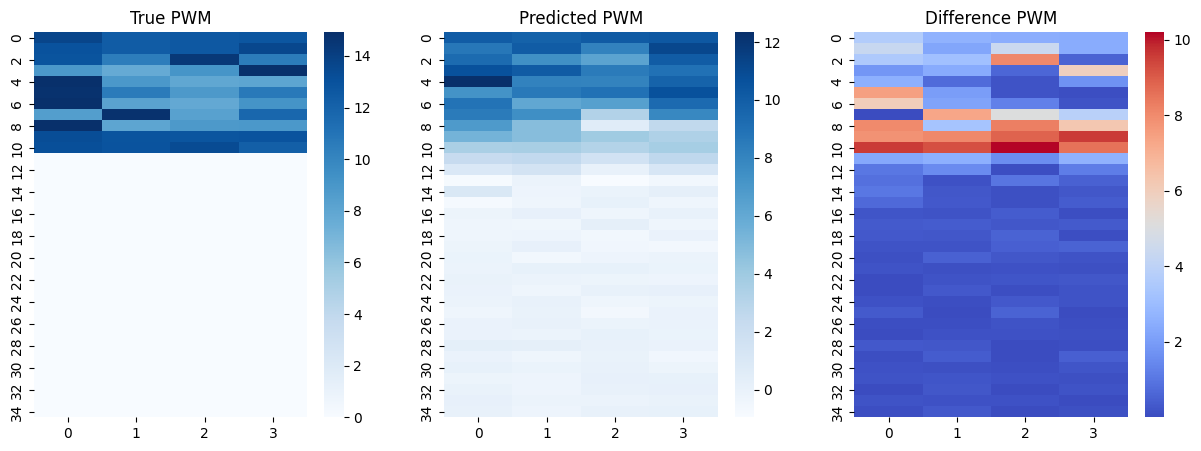

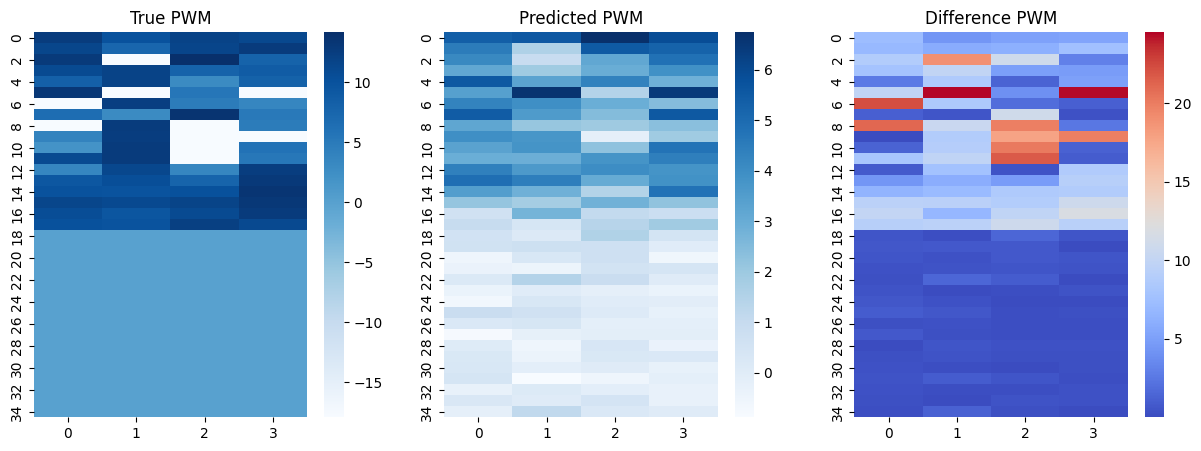

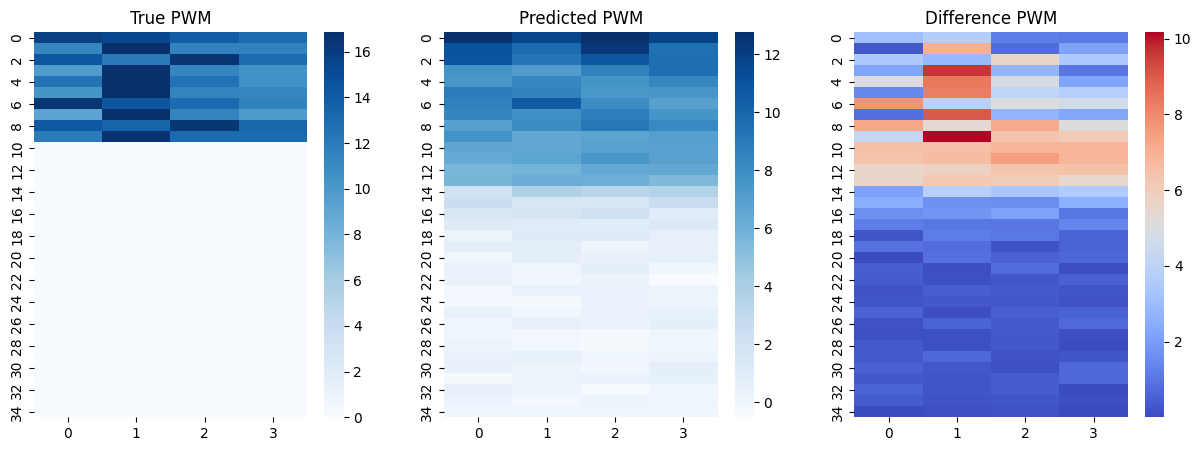

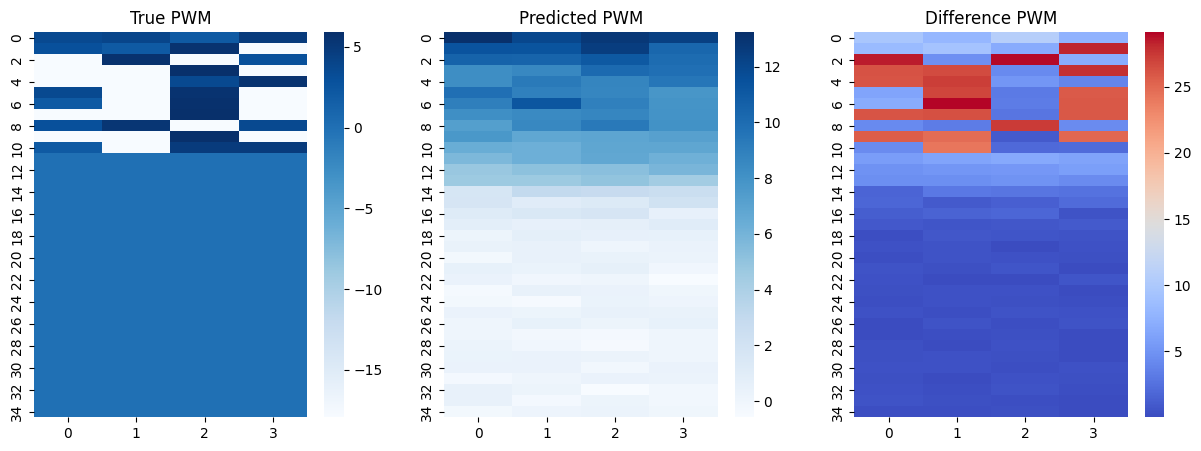

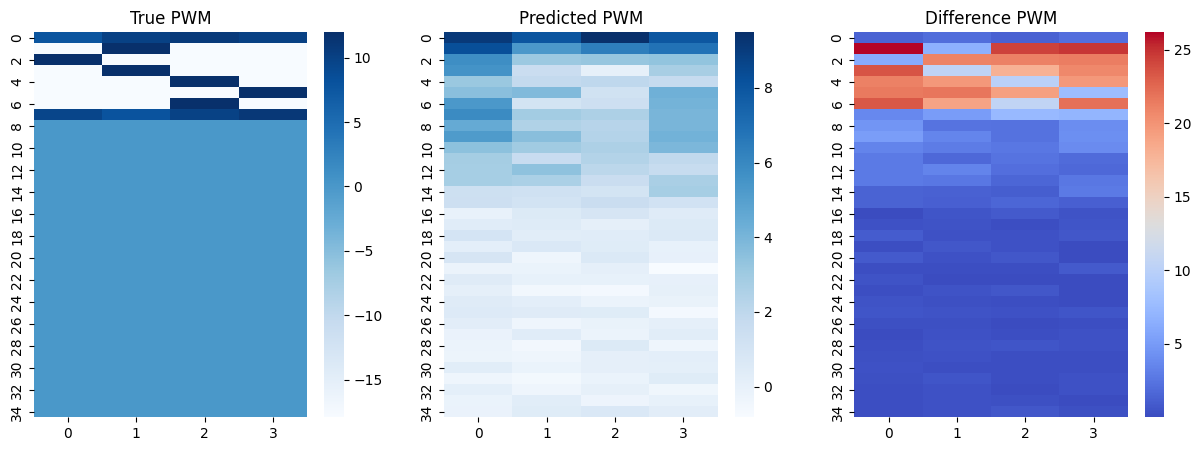

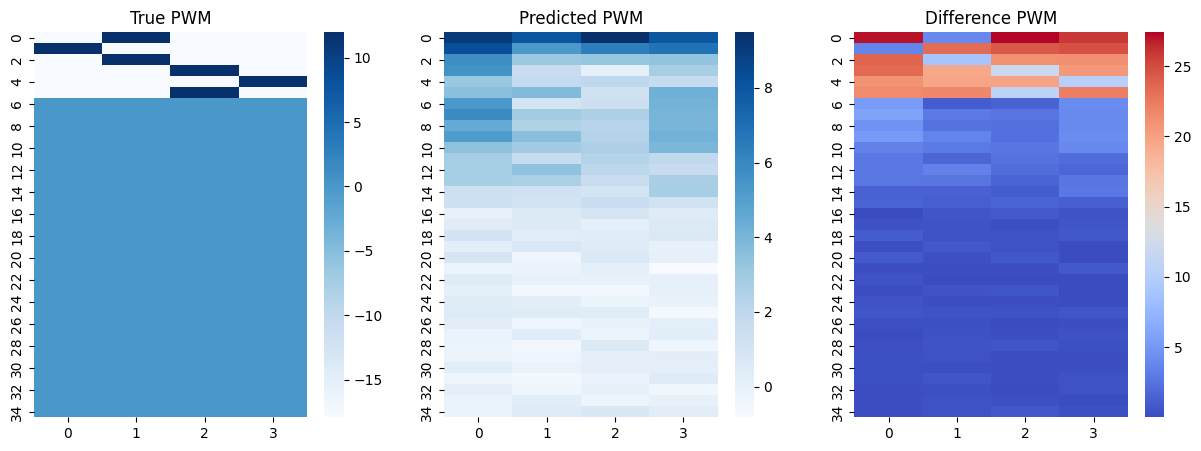

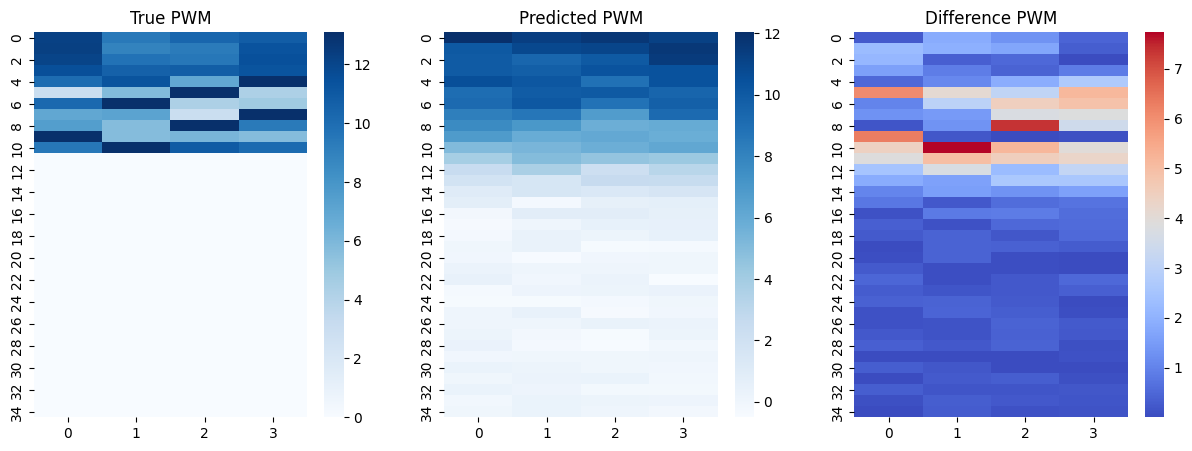

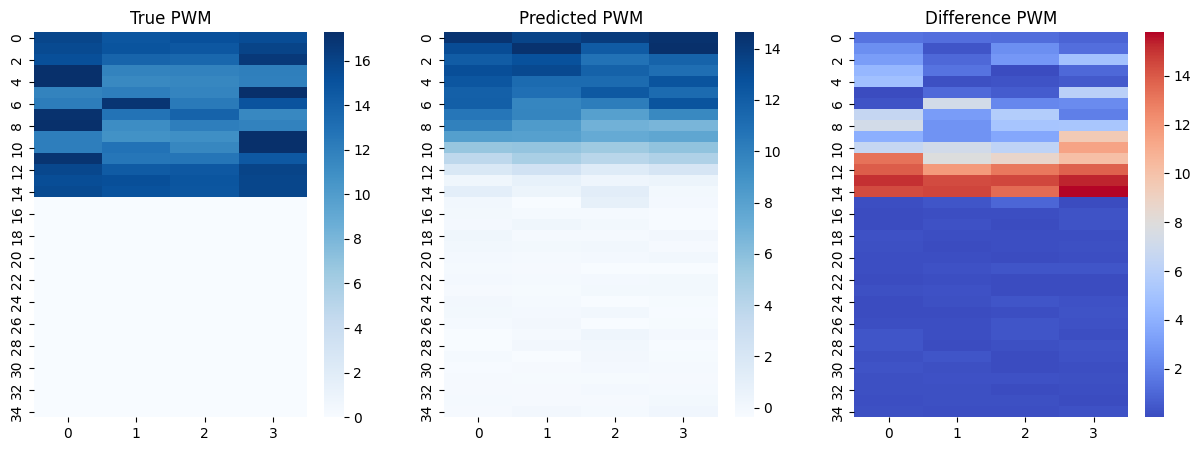

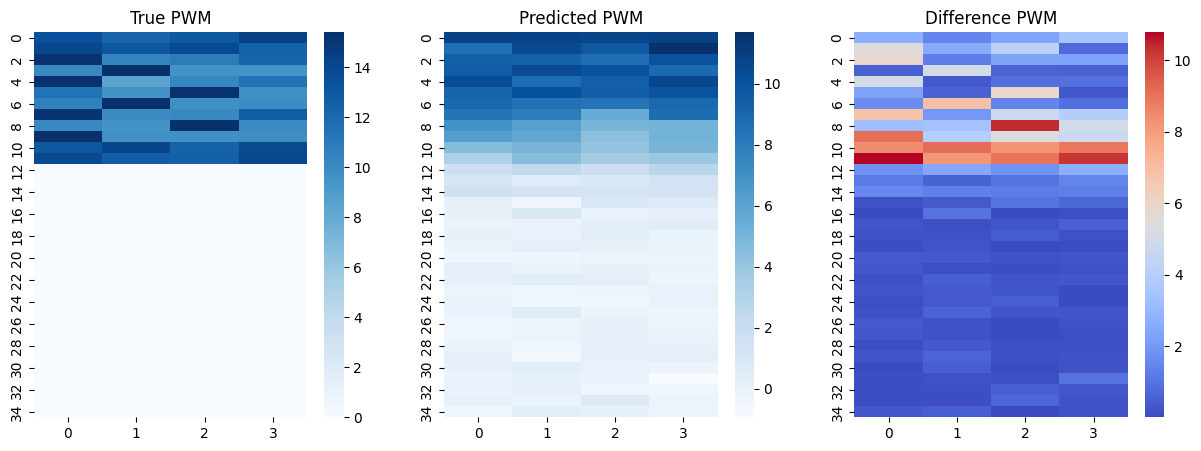

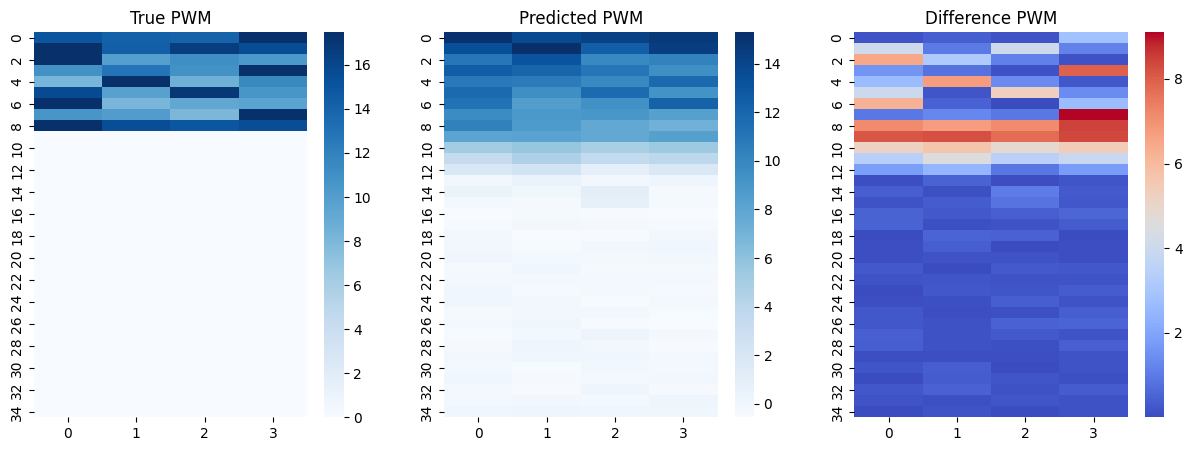

In [73]:
for i in range(10):  # Visualize first 3 samples
    true_pwm = all_ground_truths[i]
    predicted_pwm = all_predictions[i]
    diff_pwm = np.abs(true_pwm - predicted_pwm)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    sns.heatmap(true_pwm, ax=axes[0], cmap="Blues", cbar=True)
    axes[0].set_title("True PWM")
    sns.heatmap(predicted_pwm, ax=axes[1], cmap="Blues", cbar=True)
    axes[1].set_title("Predicted PWM")
    sns.heatmap(diff_pwm, ax=axes[2], cmap="coolwarm", cbar=True)
    axes[2].set_title("Difference PWM")
    plt.savefig(f'../results/esm/v1_0/esm2_t6_8M_UR50D/17536149/pwm_comparison_{i}.png')

Worst Sample Index: 336, MSE: 162.3643
Ground Truth PWM:
 [[  4.32192838   2.00000144   2.00000144 -17.93156857]
 [  2.00000144   4.32192838   2.00000144 -17.93156857]
 [  2.00000144   4.58496274 -17.93156857 -17.93156857]
 [-17.93156857 -17.93156857   4.80735513 -17.93156857]
 [-17.93156857 -17.93156857   4.80735513 -17.93156857]
 [  4.80735513 -17.93156857 -17.93156857 -17.93156857]
 [  4.80735513 -17.93156857 -17.93156857 -17.93156857]
 [-17.93156857 -17.93156857   4.80735513 -17.93156857]
 [  3.58496298   2.00000144   2.00000144   3.00000072]
 [-17.93156857   3.00000072   4.00000036   2.00000144]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [  0.           0.           0.           0.        ]
 [  0. 

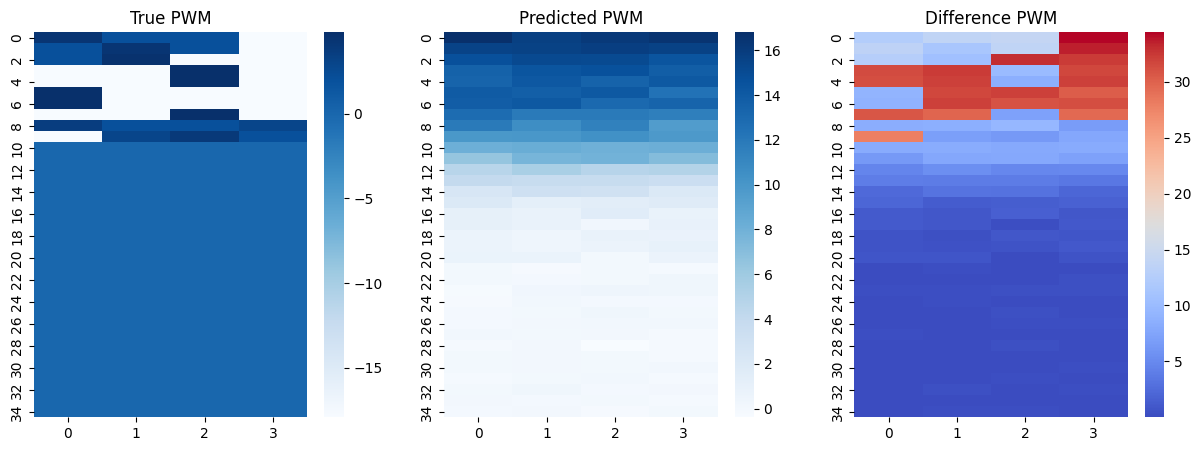

In [74]:
worst_idx = np.argmax(errors)
print(f"Worst Sample Index: {worst_idx}, MSE: {errors[worst_idx]:.4f}")
print("Ground Truth PWM:\n", all_ground_truths[worst_idx])
print("Predicted PWM:\n", all_predictions[worst_idx])

worst_idx = np.argmax(errors)
true_pwm = all_ground_truths[worst_idx]
predicted_pwm = all_predictions[worst_idx]

# Heatmap comparison for worst-case sample
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.heatmap(true_pwm, ax=axes[0], cmap="Blues", cbar=True)
axes[0].set_title("True PWM")
sns.heatmap(predicted_pwm, ax=axes[1], cmap="Blues", cbar=True)
axes[1].set_title("Predicted PWM")
sns.heatmap(np.abs(true_pwm - predicted_pwm), ax=axes[2], cmap="coolwarm", cbar=True)
axes[2].set_title("Difference PWM")
plt.savefig(f'../results/esm/v1_0/esm2_t6_8M_UR50D/17536149/pwm_comparison_worst.png')

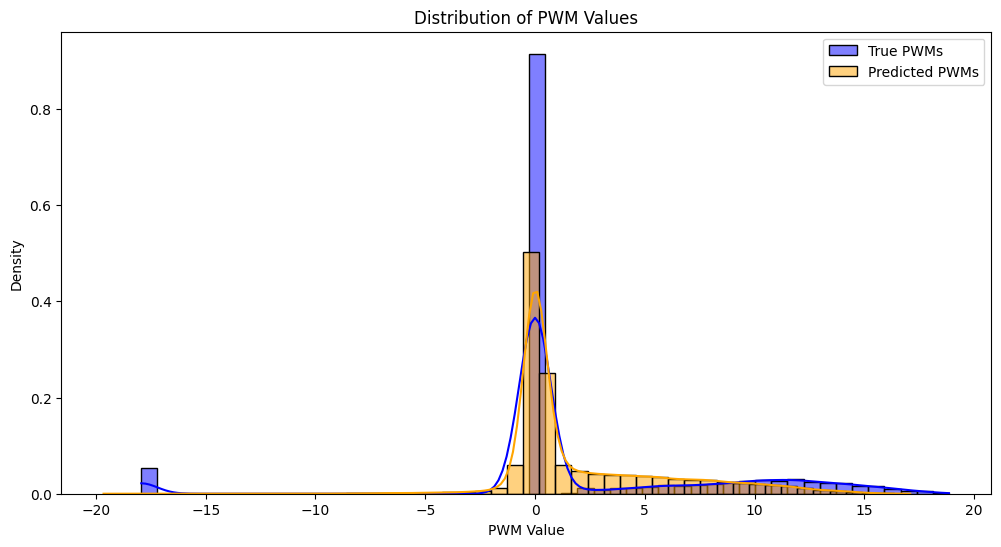

In [75]:
# Flatten all true and predicted PWMs
true_pwm_values = all_ground_truths.flatten()
predicted_pwm_values = all_predictions.flatten()

# Plot the distribution
plt.figure(figsize=(12, 6))
sns.histplot(true_pwm_values, bins=50, color="blue", label="True PWMs", kde=True, stat="density", alpha=0.5)
sns.histplot(predicted_pwm_values, bins=50, color="orange", label="Predicted PWMs", kde=True, stat="density", alpha=0.5)

# Add labels and legend
plt.xlabel("PWM Value")
plt.ylabel("Density")
plt.title("Distribution of PWM Values")
plt.legend()
plt.savefig(f'../results/esm/v1_0/esm2_t6_8M_UR50D/17536149/pwm_distributions.png')

In [72]:
# Check for -17 in padded regions
negative_peak = np.sum(all_ground_truths <= -17.93)
print(f"Occurrences of -17 in true PWMs: {negative_peak}")
# Find indices of PWMs with the specific value
indices_with_value = np.where(np.any(all_ground_truths <= -17.93, axis=(1, 2)))[0]

print(f"Indices of PWMs containing {-17.93}: {indices_with_value}")

Occurrences of -17 in true PWMs: 2127
Indices of PWMs containing -17.93: [  1   3   4   5  10  11  12  13  14  15  16  20  24  25  26  27  29  30
  31  36  37  40  41  42  43  44  51  52  53  54  55  57  59  62  63  64
  65  66  68  69  70  71  72  73  74  75  77  78  79  80  82  83  84  85
  87  88  90  92  93  94  96  97  99 103 104 105 108 109 112 113 114 115
 116 117 118 119 120 122 123 124 125 126 128 129 130 131 137 138 139 144
 150 151 153 154 155 157 159 160 161 164 165 166 167 168 169 172 173 174
 175 176 177 178 180 181 183 185 187 188 189 190 191 192 193 195 196 197
 198 199 200 202 203 206 208 209 210 217 218 219 221 222 223 224 226 227
 228 229 230 232 234 237 239 240 241 242 243 244 245 246 247 248 249 250
 253 254 258 259 260 263 264 268 269 270 273 274 275 276 277 278 279 281
 282 283 284 285 287 288 291 292 293 294 296 297 298 299 301 302 304 305
 306 307 308 309 310 313 314 315 316 317 318 319 320 323 324 327 328 331
 333 336 337 338 339 340 341 342 344 345 346 347 34

In [70]:
all_ground_truths <= -17.93

array([[[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        ...,
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]],

       [[False, False, False, False],
        [False, False, False, False],
        [False,  True, False, False],
        ...,
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]],

       [[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        ...,
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]],

       ...,

       [[False, False, False, False],
        [False, False, False, False],
        [False, False, False, False],
        ...,
        [False, False, False, False],
        [False, False, False, False],
        [False, False, False, False]],

       [[False,

In [3]:
model_runs = ['17536149']#, '17536308', '17536317']

for model_cat in os.listdir('../models/esm'):
    for model_run in os.listdir(f'../models/esm/{model_cat}'):
        if model_run in model_runs:
            config_file = f'../models/esm/{model_cat}/{model_run}/model_config.pth'
            weights_file = f'../models/esm/{model_cat}/{model_run}/model_weights.pth'
            print(f'config_file: {config_file}')

            model = cesm.load_model(weights_file, config_file, model_cat)
            model.eval()
            with torch.no_grad():
                predictions[model_run] = model(test_data['AA Sequence'].values)
                


config_file: ../models/esm/esm2_t6_8M_UR50D/17536149/model_config.pth


/hpc/mydata/anton.thieme/projects/TabulaSapiens/notebooks/../src/ts_tf/custom_esm.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  config = torch.load(config_path)
Using

Output shape: (35, 4)
<class 'esm.data.Alphabet'>


/hpc/mydata/anton.thieme/projects/TabulaSapiens/notebooks/../src/ts_tf/custom_esm.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weig

In [ ]:
print(f'prediction keys: {predictions.keys()}')
print(f'prediction values: {predictions.values()}')
print(f'type of prediction values: {type(predictions.values())}')

prediction keys: dict_keys(['17536149'])
prediction values: dict_values([tensor([[[ 1.0058e+01,  9.7685e+00,  1.0125e+01,  1.0293e+01],
         [ 8.6695e+00,  1.0097e+01,  8.1817e+00,  1.1159e+01],
         [ 9.3102e+00,  7.4042e+00,  6.3429e+00,  1.0073e+01],
         ...,
         [ 1.4584e-02, -2.4370e-01,  2.9954e-02,  1.7510e-01],
         [ 1.7624e-01, -1.4540e-01, -1.4769e-01,  9.8786e-03],
         [ 7.5000e-02, -2.8144e-01,  3.6052e-02,  9.2481e-02]],

        [[ 5.3455e+00,  5.5564e+00,  6.7419e+00,  5.8789e+00],
         [ 4.5361e+00,  1.5809e+00,  5.4992e+00,  5.2430e+00],
         [ 4.1250e+00,  9.6016e-01,  3.1560e+00,  4.8122e+00],
         ...,
         [-2.9797e-01,  1.5576e-01, -1.3105e-01, -3.0722e-01],
         [ 2.9431e-01,  4.5774e-02,  4.5809e-01, -3.0573e-01],
         [-1.9538e-01,  1.1623e+00,  2.2638e-01,  6.6918e-02]],

        [[ 1.2749e+01,  1.1634e+01,  1.2694e+01,  1.1808e+01],
         [ 1.1011e+01,  9.7710e+00,  1.2297e+01,  9.4686e+00],
         [ 1.

In [26]:
test_df = pd.read_csv("../data/esm/test_data.csv")
test_df["prediction"] = None
type(test_df['pwm'][0])

str

In [20]:
test_df

,AA Sequence,Collection,Gene Name,Matrix ID,Motif ID,Name,Species,Taxonomy ID,UniProt ID,pwm,pfm,prediction
0,MAAAAAALSGAGTPPAGGGAGGGGAGGGGSPPGGWAVARLEGREFE...,CORE,FOXK2,MA1103.1,MA1103.1,FOXK2,Homo sapiens,9606,Q01167,"[[13.7095146611375, 12.40194612504283, 12.6128...","[[3349.0, 1353.0, 1566.0, 1709.0], [2030.0, 13...",None
1,MAAAAYVDHFAAECLVSMSSRAVVHGPREGPESRPEGAAVAATPTL...,CORE,KLF13,MA0657.1,MA0657.1,KLF13,Homo sapiens,9606,Q9Y2Y9,"[[12.558420714225358, 9.954196316204191, 11.83...","[[1508.0, 248.0, 915.0, 590.0], [733.0, 46.0, ...",None
2,MAAAKAEMQLMSPLQISDPFGSFPHSPTMDNYPKLEEMMLLSNGAP...,CORE,EGR1,MA0162.5,MA0162.5,EGR1,Homo sapiens,9606,P18146,"[[15.824561030069722, 15.330776858354414, 13.9...","[[14508.0, 10303.0, 3854.0, 1933.0], [642.0, 2...",None
3,MAAAKAEMQLMSPLQISDPFGSFPHSPTMDNYPKLEEMMLLSNGAP...,CORE,Egr1,MA0162.1,MA0162.1,Egr1,Mus musculus,10090,P08046,"[[3.584962981619423, 4.000000360673715, 2.0000...","[[3.0, 4.0, 1.0, 7.0], [2.0, 1.0, 12.0, 0.0], ...",None
4,MAADVFMCSPRRPRSRGRSVLLKPQVPEDDDDSDTDEPSPPPPSGV...,CORE,Mlxip,MA0622.1,MA0622.1,Mlxip,Mus musculus,10090,Q2VPU4,"[[7.72792048178386, 10.038918994777834, 10.717...","[[53.0, 263.0, 421.0, 263.0], [0.0, 999.0, 0.0...",None
...,...,...,...,...,...,...,...,...,...,...,...,...
376,MYQSLALAASPRQAAYADSGSFLHAPGAGSPMFVPPARVPSMLSYL...,CORE,GATA5,MA0766.1,MA0766.1,GATA5,Homo sapiens,9606,Q9BWX5,"[[13.203959703851034, 11.994353438273263, 9.37...","[[2359.0, 1020.0, 166.0, 1743.0], [0.0, 0.0, 2...",None
377,MYQSLAMAANHGPPPGAYEAGGPGAFMHGAGAASSPVYVPTPRVPS...,CORE,GATA4,MA0482.2,MA0482.2,GATA4,Homo sapiens,9606,P43694,"[[15.836839359847316, 15.521723112780515, 15.4...","[[14632.0, 11761.0, 11083.0, 21538.0], [13534....",None
378,MYSPYCLTQDEFHPFIEALLPHVRAFSYTWFNLQARKRKYFKKHEK...,CORE,NFIX,MA0671.2,MA0671.2,NFIX,Homo sapiens,9606,Q14938,"[[15.461351543247938, 15.243025183142963, 14.5...","[[11279.0, 9695.0, 5911.0, 32864.0], [132.0, 1...",None
379,MYVGYVLDKDSPVYPGPARPASLGLGPQAYGPPAPPPAPPQYPDFS...,CORE,CDX1,MA0878.3,MA0878.3,CDX1,Homo sapiens,9606,P47902,"[[12.087462842576349, 11.78790256102344, 14.87...","[[1088.0, 884.0, 7528.0, 1076.0], [527.0, 355....",None


In [22]:
print(f'len of test_df: {len(test_df)}')
print(f'len of predictions: {len(predictions["17536149"])}')

len of test_df: 381
len of predictions: 381


In [25]:
test_df['prediction'] = [pred.item() for pred in predictions['17536149']]
test_df

RuntimeError: a Tensor with 140 elements cannot be converted to Scalar